In [347]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [348]:
import pandas as pd
import datetime
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV


from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from math import log as log
import os

# Information

In [349]:
path = '/kaggle/input/sf-dst-scoring/'

In [350]:
train = pd.read_csv(path +'train.csv')
test = pd.read_csv(path +'test.csv')
sample = pd.read_csv(path +'sample_submission.csv')

In [351]:
print(train.info())
print('Train size: ', train.shape)
train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [352]:
train.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [353]:
test.isna().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

хмм.. пропуски в education, Y/N - чисто бинарные значения в некоторых признаках

In [354]:
print(test.info())
print('Test size: ', test.shape)
test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [355]:
print(sample.info())
print(sample.shape)
sample.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB
None
(24354, 2)


,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


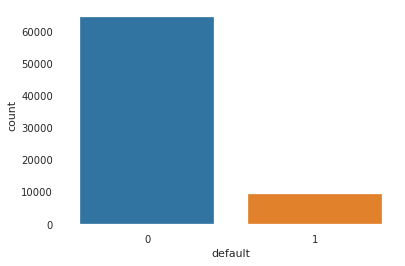

In [356]:
# распределение классов в трейне
plot = sns.countplot(train['default'])

## *Data Description:*
client_id - identification

education - education level

sex - sex

age - age

car - binary/ has a car or not

car_type - whether car is international

decline_app_cnt - declined application count in the past

good_work - binary/ has 'good' work or not

bki_request_cnt - requests to BKI

home_address - category of home address

work_address - category of work address

income - income

foreign_passport - binary/ has foreign passport

sna - connection with bank employee

first_time - age of information about the client

score_bki - BKI score

region_rating - region rating

app_date - application date

default - default flag

# EDA: классифицируем признаки по типу.

In [357]:
num_cols = ['age','decline_app_cnt','score_bki','income','bki_request_cnt','region_rating'] 
cat_cols = ['work_address','home_address','sna','first_time'] 
bin_cols = ['sex','car','car_type','good_work','foreign_passport'] 
ord_cols = ['education'] # порядковый!
target_col = 'default'

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


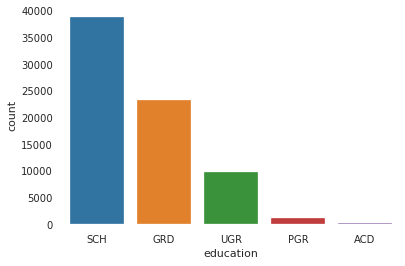

In [358]:
plot = sns.countplot(train['education'])

В education прослеживается явно ординарная природа. Закодируем.
SHC - school,
UGR - undergraduate = бакалавр,
GRD = graduate degree,
а PGR+ACD = (postgraduate, academic) - объединим в 1
В прочих признаках закодируем Y/N, male/female -> 1,0  и прочие категориальные метки

In [359]:
def ReplaceEdu(x):
    if x=='SCH': return 0
    if x=='UGR': return 1
    if x=='GRD': return 2
    if x=='PGR': return 3
    if x=='ACD': return 3
    return None

def Encode(df):
    mapp = {}
    label_encoder = LabelEncoder()
    for col in bin_cols:
        df[col] = label_encoder.fit_transform(df[col])
        mapp[col] = dict(enumerate(label_encoder.classes_))


    mappc = {}
    enc = OneHotEncoder()
    for col in cat_cols:
        df[col] = label_encoder.fit_transform(df[col])
        mappc[col] = dict(enumerate(label_encoder.classes_))
        
    print(mapp)
    print(mappc)        
    return df

train.education = train.education.apply(lambda x: ReplaceEdu(x))
test.education = test.education.apply(lambda x: ReplaceEdu(x))
train = Encode(train)
test = Encode(test)
    



{'sex': {0: 'F', 1: 'M'}, 'car': {0: 'N', 1: 'Y'}, 'car_type': {0: 'N', 1: 'Y'}, 'good_work': {0: 0, 1: 1}, 'foreign_passport': {0: 'N', 1: 'Y'}}
{'work_address': {0: 1, 1: 2, 2: 3}, 'home_address': {0: 1, 1: 2, 2: 3}, 'sna': {0: 1, 1: 2, 2: 3, 3: 4}, 'first_time': {0: 1, 1: 2, 2: 3, 3: 4}}
{'sex': {0: 'F', 1: 'M'}, 'car': {0: 'N', 1: 'Y'}, 'car_type': {0: 'N', 1: 'Y'}, 'good_work': {0: 0, 1: 1}, 'foreign_passport': {0: 'N', 1: 'Y'}}
{'work_address': {0: 1, 1: 2, 2: 3}, 'home_address': {0: 1, 1: 2, 2: 3}, 'sna': {0: 1, 1: 2, 2: 3, 3: 4}, 'first_time': {0: 1, 1: 2, 2: 3, 3: 4}}


In [360]:
train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,0.0,1,62,1,1,0,0,-2.008753,1,50,0,1,18000,3,0,0,0
1,63161,12MAR2014,0.0,0,59,0,0,0,0,-1.532276,3,50,1,2,19000,3,0,0,0
2,25887,01FEB2014,0.0,1,25,1,0,2,0,-1.408142,1,80,0,1,30000,0,3,1,0
3,16222,23JAN2014,0.0,0,53,0,0,0,0,-2.057471,2,50,1,2,10000,0,2,0,0
4,101655,18APR2014,2.0,1,48,0,0,0,1,-1.244723,1,60,1,2,30000,0,3,1,0


In [361]:
test.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,2.0,1,29,1,1,0,0,-2.271884,3,50,0,1,50000,0,3,0
1,17527,24JAN2014,0.0,0,39,0,0,5,0,-1.504999,2,50,0,1,5000,3,2,0
2,75683,23MAR2014,1.0,1,50,1,1,0,0,-1.691339,1,50,0,1,30000,0,2,1
3,26883,03FEB2014,0.0,1,56,0,0,0,0,-2.374182,1,40,0,1,17000,0,2,0
4,28862,04FEB2014,2.0,0,38,0,0,0,0,-2.487502,0,80,1,2,120000,0,2,0


In [362]:
# разметим для простоты
train['sample'] = 1   # train
test['sample'] = 0    # test
test['default'] = -1  
data = train.append(test, sort=False).reset_index(drop=True)
print(data.info())
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  float64
 3   sex               110148 non-null  int64  
 4   age               110148 non-null  int64  
 5   car               110148 non-null  int64  
 6   car_type          110148 non-null  int64  
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

(110148, 20)

In [363]:
data.describe()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
count,110148.000000,109670.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,0.827501,0.438610,39.249410,0.325544,0.190725,0.273205,0.165514,-1.904535,2.005002,56.751189,0.574945,1.497867,41012.648537,0.731588,1.765570,0.149136,-0.244916,0.669999
std,31797.133063,0.945914,0.496219,11.518063,0.468580,0.392875,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.356224,0.595908,0.470215
min,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,0.000000,0.000000,1000.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,27537.750000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,0.000000,1.000000,20000.000000,0.000000,1.000000,0.000000,-1.000000,0.000000
50%,55074.500000,0.000000,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,1.000000,2.000000,30000.000000,0.000000,2.000000,0.000000,0.000000,1.000000
75%,82611.250000,2.000000,1.000000,48.000000,1.000000,0.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,1.000000,2.000000,48000.000000,1.000000,3.000000,0.000000,0.000000,1.000000
max,110148.000000,3.000000,1.000000,72.000000,1.000000,1.000000,33.000000,1.000000,0.199773,53.000000,80.000000,2.000000,2.000000,1000000.000000,3.000000,3.000000,1.000000,1.000000,1.000000


# анализируем вещественные признаки

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


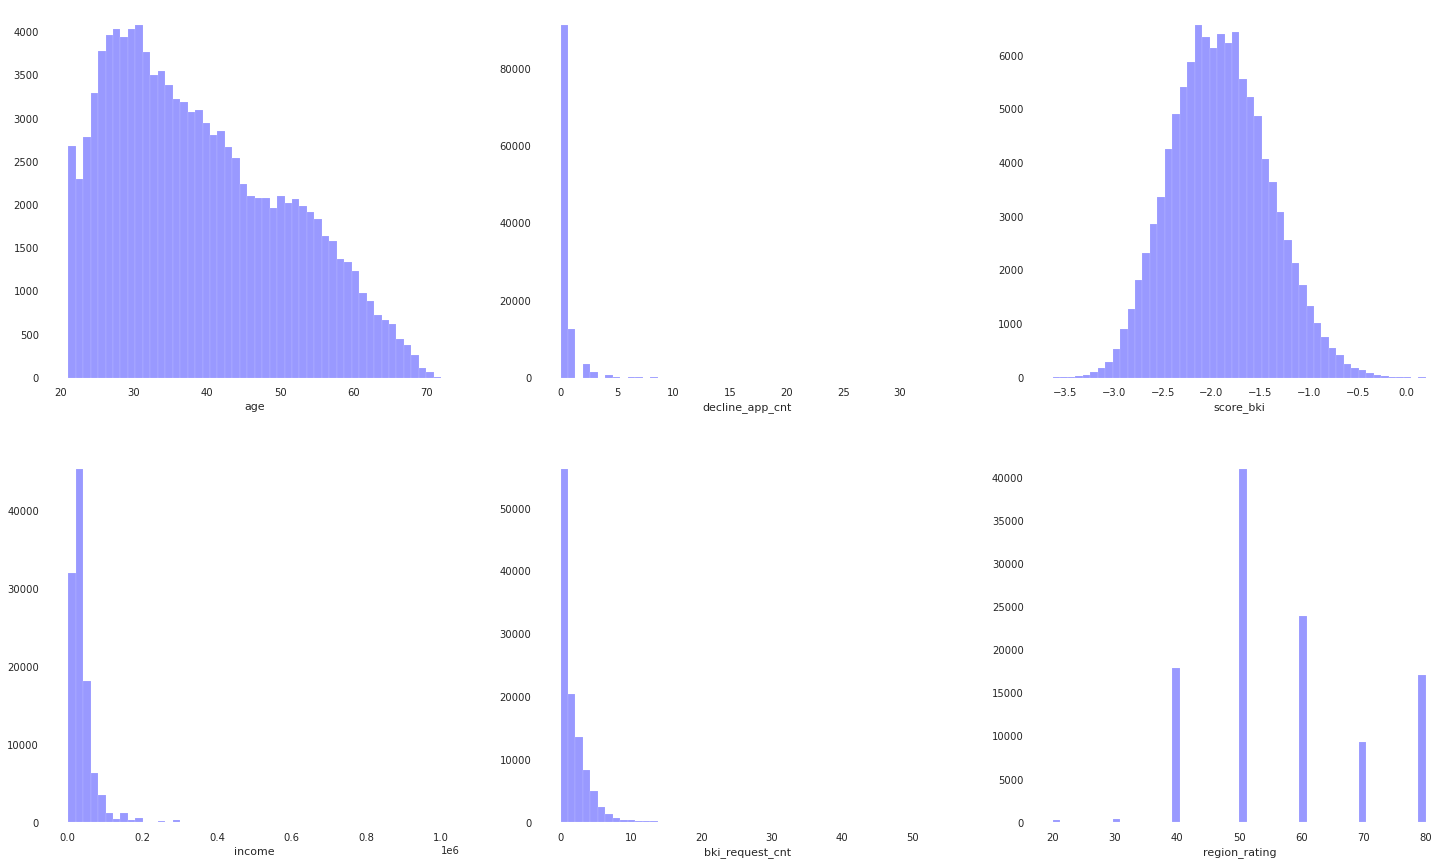

In [364]:
# Let's look at numerical data
fig, axes = plt.subplots(2, 3, figsize=(25,15))

for i,col in enumerate(num_cols):
    sns.distplot(data[col], kde=False, ax=axes.flat[i], color="b")

### распределение 'decline_app_cnt', 'income', 'bki_request_cnt' смещено влево. прологарифмируем их, чтобы добиться более "правильной" нормальности.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

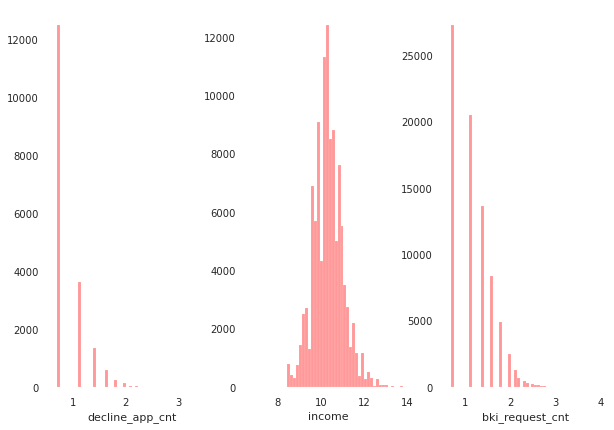

In [365]:
fig, axes = plt.subplots(1, 3, figsize=(10,7))
for i,col in enumerate(['decline_app_cnt', 'income', 'bki_request_cnt']):
    data[col] = np.log(data[col] + 1)
    sns.distplot(data[col][data[col] > 0].dropna(), ax=axes.flat[i],kde = False, rug=False,color="r")
    
    

## так-то лучше.

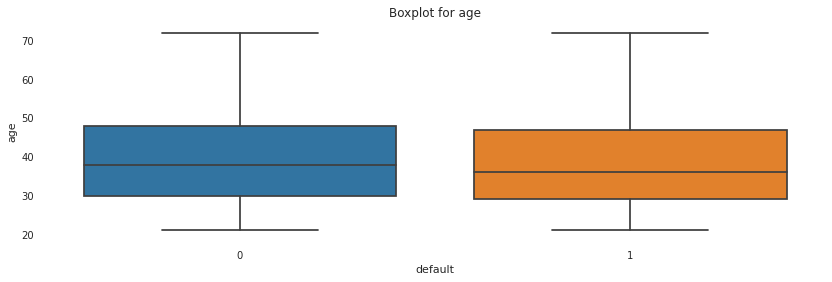

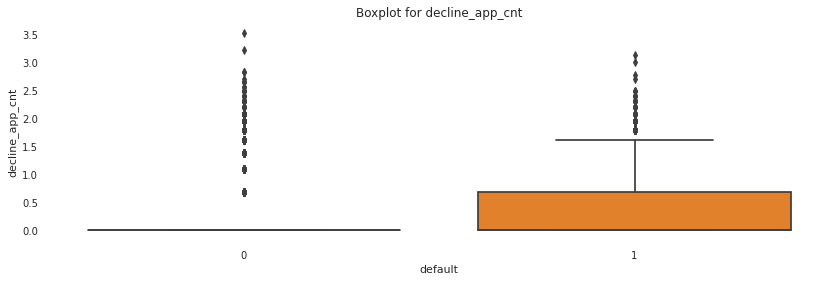

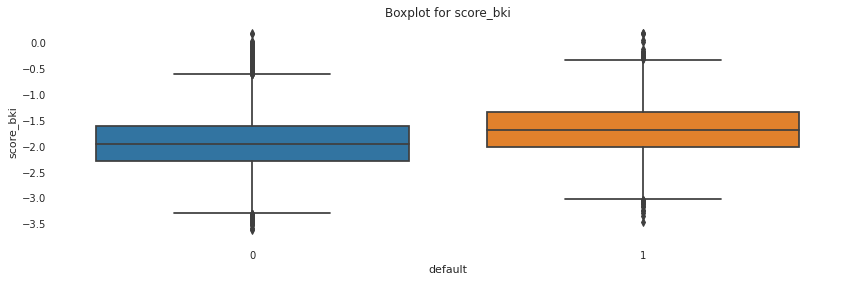

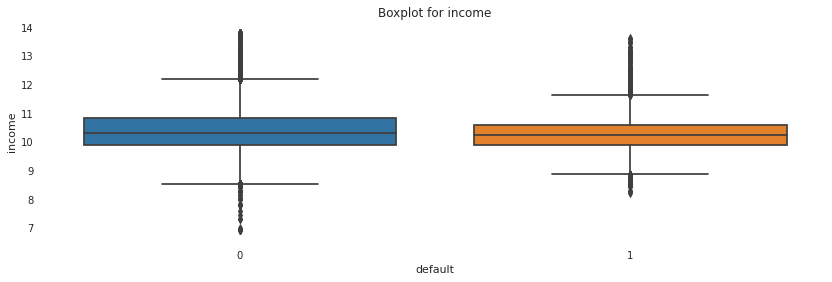

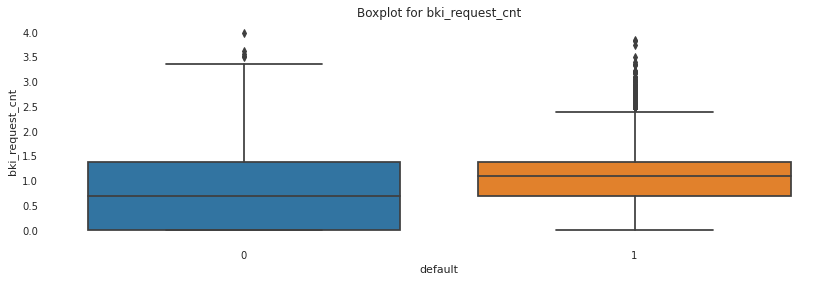

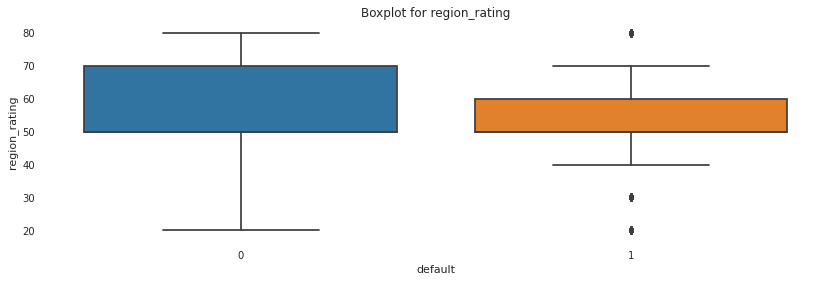

In [366]:
def boxplot(col):
    fig, axes = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='default', y=col, data=data[data['sample']==1],ax=axes)
    axes.set_title('Boxplot for ' + col)
    plt.show()
    
for col in num_cols:
    boxplot(col)

## Простые закономерности для дефолтных граждан (по сравнению с недефолтными):

* младше

* скоринг БКИ выше.

* Region rating влияет.

* BKI requests (кол-во обращений в БКИ) выше.

* income (доход) ниже.

<AxesSubplot:>

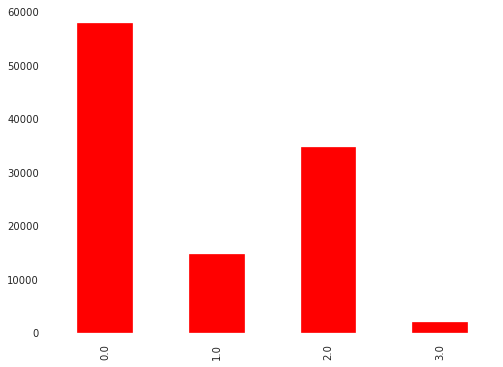

In [367]:
data.education.value_counts().plot(kind="bar",figsize=(8,6),color="r")

# заполним пропуски в education творческим методом - машинного обучения, решая задачу классификации
но для упрощения введем 2 функции, которые помогут нам в будущем при любом машинном обучении в задаче классификации

In [368]:
# метод универсально готовит train/test выборку для любой ML задачи по размеченным признакам. 
# выдергивает из датафрейма numpy-массив данных, кодирует категориальный признаки в One-hot, 
# числовые и ординальные нормализует, а бинарные просто копирует,
# затем генерит полиномиальные и нормализует, и режет все это на train/valid части
def GetSelection(df, num_cols, bin_cols, cat_cols, ord_cols, target_col, 
                 test_size=0.2, shuffle=True, random_state=42):
    #удалим из ML-выборки лишние бессмысленные признаки (если они там есть)
    try:
        df = df.drop(['sample'], axis=1)
    except:
        pass
    
    try:
        df = df.drop(['client_id'], axis=1)
    except:
        pass
    
    labels = df.columns.to_list()
    
    X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)
    X_bin = df[bin_cols].values
    X_num_ord = StandardScaler().fit_transform(df[num_cols+ord_cols].values)
    
    poly_numord = PolynomialFeatures(degree=2) #полиномиальные степени 2 для численных и ординальных с полной комбинаторикой
    poly_bin = PolynomialFeatures(degree=2, interaction_only=True) #полиномиальные степени 2 для бинарных только с разно-признаковыми сочетаниями
    
    X_numord_poly = StandardScaler().fit_transform(poly_numord.fit_transform(df[num_cols+ord_cols].values))
    X_bin_poly = poly_bin.fit_transform(df[bin_cols].values)
    #X = np.hstack([X_num_ord, X_cat, X_bin])
    
    X = np.hstack([X_num_ord, X_cat, X_bin, X_numord_poly, X_bin_poly])
    Y = df[target_col].values
    
    
    if (test_size==1.0):
        return X,Y

    X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=test_size, shuffle=shuffle, random_state=random_state)
    return X_train, X_valid, Y_train, Y_valid


#подсчет и визуализация F1, Confusion matrix и ROC AUC на train/test
def CalcMetrics(X_train, X_test, 
                Y_train, Y_test,
                Y_train_pred, Y_test_pred, multiclass=False):
    
    if multiclass:
        print('[train] precision = {:.2f}'.format(precision_score(Y_train, Y_train_pred, average='micro')))
        print('[valid] precision = {:.2f}'.format(precision_score(Y_test, Y_test_pred, average='micro')))
        print('[train] recall = {:.2f}'.format(recall_score(Y_train, Y_train_pred, average='micro')))
        print('[valid] recall = {:.2f}'.format(recall_score(Y_test, Y_test_pred, average='micro')))    
        print('[train] F1-score = {:.2f}'.format(f1_score(Y_train, Y_train_pred, average='micro')))
        print('[valid] F1-score = {:.2f}'.format(f1_score(Y_test, Y_test_pred, average='micro')))
        cm = confusion_matrix(Y_test, Y_test_pred)
        cmd = ConfusionMatrixDisplay(cm)
        cmd.plot()
        cmd.ax_.set(xlabel='Predicted', ylabel='True')     
        return 

    
    print('[train] precision = {:.2f}'.format(precision_score(Y_train, Y_train_pred, average='binary')))
    print('[valid] precision = {:.2f}'.format(precision_score(Y_test, Y_test_pred, average='binary')))
    print('[train] recall = {:.2f}'.format(recall_score(Y_train, Y_train_pred, average='binary')))
    print('[valid] recall = {:.2f}'.format(recall_score(Y_test, Y_test_pred, average='binary')))    
    print('[train] F1-score = {:.2f}'.format(f1_score(Y_train, Y_train_pred, average='binary')))
    print('[valid] F1-score = {:.2f}'.format(f1_score(Y_test, Y_test_pred, average='binary')))
    cm = confusion_matrix(Y_test, Y_test_pred)
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()
    cmd.ax_.set(xlabel='Predicted', ylabel='True')     
    
    # считаем вероятности и ROCAUC обучающей (X_train, y_train) выборки
    y_train_probs = classifier.predict_proba(X_train)
    y_train_probs = y_train_probs[:,1]
    fpr_train, tpr_train, threshold_train = roc_curve(Y_train, y_train_probs)
    roc_auc_train = roc_auc_score(Y_train, y_train_probs)

    # считаем метрики тестовой (X_test, y_test) выборки
    Y_pred_probs = classifier.predict_proba(X_test)
    Y_pred_probs = Y_pred_probs[:,1]
    fpr_test, tpr_test, threshold_test = roc_curve(Y_test, Y_pred_probs)
    roc_auc_test = roc_auc_score(Y_test, Y_pred_probs)

    # строи графики метрик
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle = '--')
    plt.plot(fpr_train, tpr_train, label = 'Train')
    plt.plot(fpr_test, tpr_test, label = 'Test')
    plt.title('Logistic Regression ROC AUC Train = {a} \n Logistic Regression ROC AUC Test = {b}'
              .format(a = roc_auc_train.round(3), b = roc_auc_test.round(3)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [369]:

print("Пропусков:",data.education.isna().sum())

Пропусков: 478


найдено 478 пропусков
[train] precision = 0.45
[valid] precision = 0.44
[train] recall = 0.45
[valid] recall = 0.44
[train] F1-score = 0.45
[valid] F1-score = 0.44
education:


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0    58197
2    34873
1    14861
3     2217
Name: education, dtype: int64

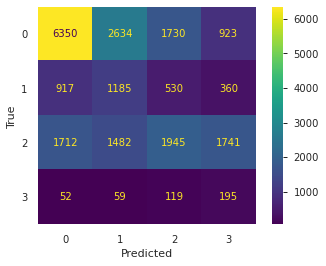

In [370]:
from sklearn.tree import DecisionTreeClassifier
dfGood = data[~pd.isna(data.education)] #часть данных с непропущенными значениями
dfMissed = data[pd.isna(data.education)] #часть данных с пропущенными значениями
if len(dfMissed)>0:
    print('найдено', len(dfMissed), 'пропусков')


    X_train, X_valid, Y_train, Y_valid = GetSelection(dfGood,
                    num_cols = num_cols,
                    bin_cols = bin_cols,
                    cat_cols = cat_cols,
                    ord_cols = [],
                    target_col = 'education') #вот только default мы выкинем, циклическая рефлексия нам некстати потом.


    classifier = DecisionTreeClassifier(max_depth=9, random_state = 42, class_weight = 'balanced')
    classifier.fit(X_train, Y_train)
    Y_pred = classifier.predict(X_valid)
    Y_train_pred = classifier.predict(X_train)
    CalcMetrics(X_train, X_valid, Y_train, Y_valid, Y_train_pred, Y_pred, multiclass=True)

    X_valid, Y_valid = GetSelection(dfMissed,
                    num_cols = num_cols,
                    bin_cols = bin_cols,
                    cat_cols = cat_cols,
                    ord_cols = [],
                    target_col = 'education',
                    test_size=1.0)
    dfMissed.education = classifier.predict(X_valid)

    data.loc[dfMissed.index, 'education'] = dfMissed
    data.education = data.education.astype(int)
    print('education:')
    display(data.education.value_counts())

F1 на train/test демонстрирует отсутствие overfitting. Confusion matrix выглядит без сильных перекосов.

In [371]:
print("Пропусков:",data.education.isna().sum())


Пропусков: 0


вот и хорошо! пропусков в education больше нет.

Смотрим зависимость дохода от уровня образования

<AxesSubplot:xlabel='education', ylabel='income'>

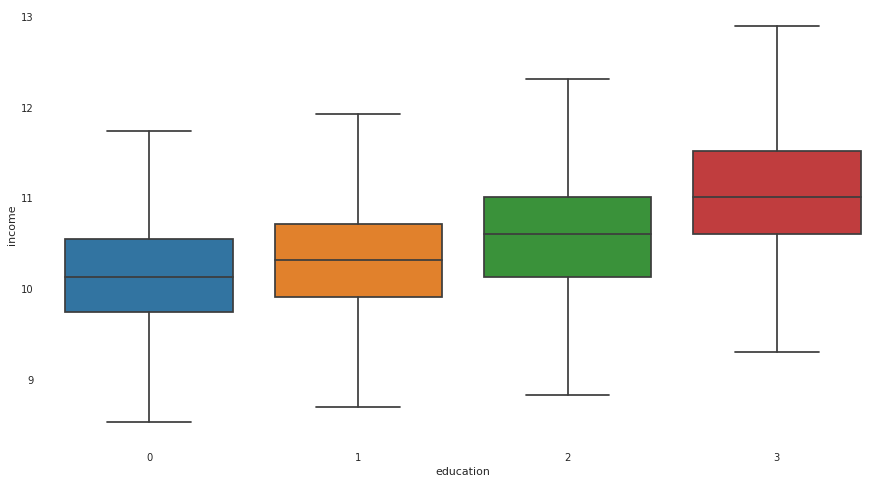

In [372]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="education", y="income", data=data, showfliers=False)

<AxesSubplot:>

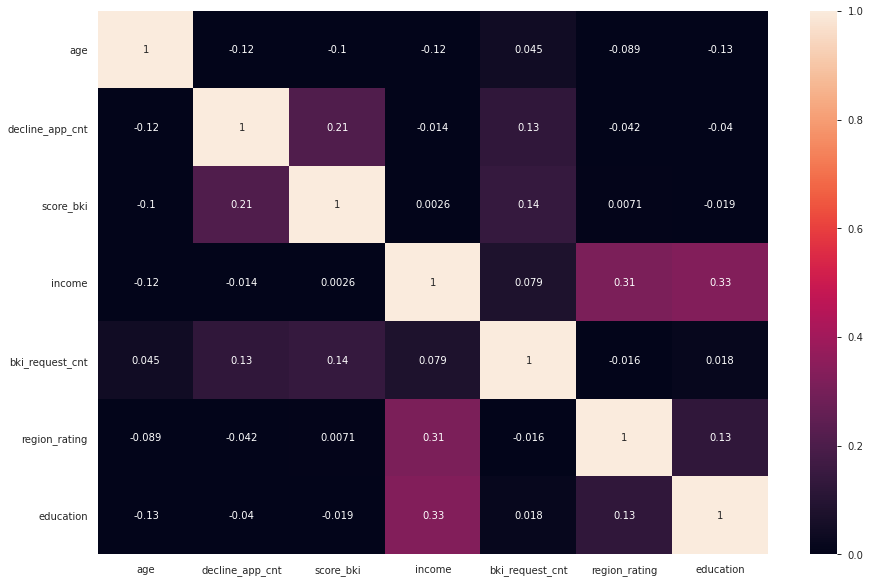

In [373]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data[num_cols + ord_cols].corr(), vmin=0, vmax=1, annot = True) 

тут все хорошо.

<AxesSubplot:>

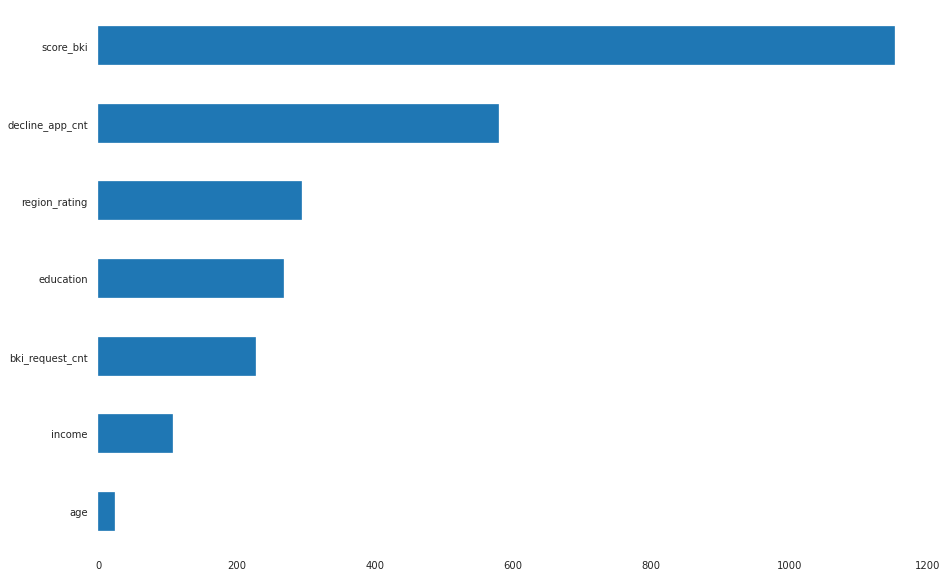

In [374]:
imp_num = pd.Series(f_classif(data[num_cols+ord_cols].values, data[target_col].values)[0], index = num_cols+ord_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

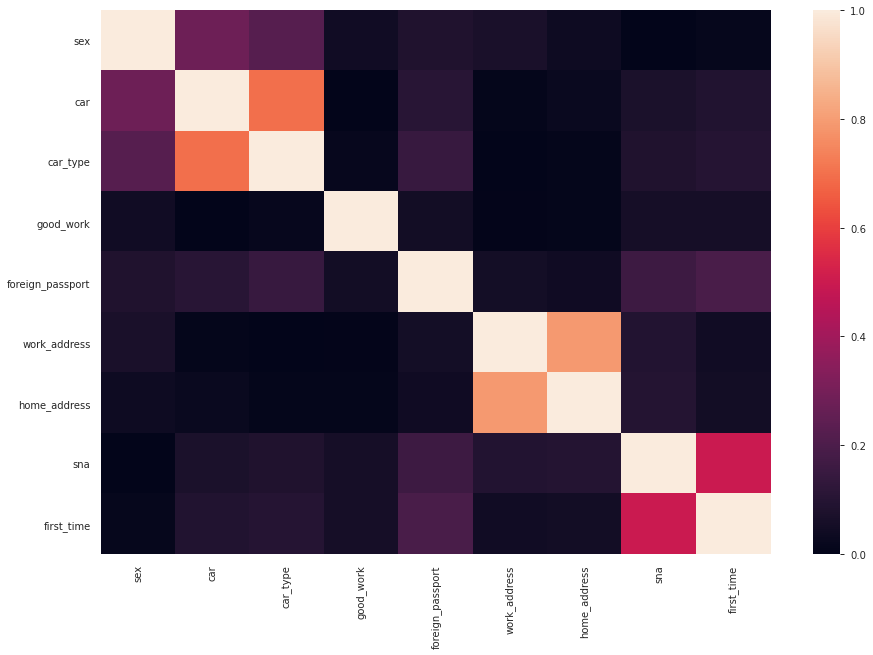

In [375]:
sns.heatmap(data[bin_cols + cat_cols].corr(method='spearman').abs(), vmin=0, vmax=1)

### Упс... car-car_type, home_address-work_address - многовато. удалим. Но сначала посмотрим важность для целевой переменной с помощью ANOVA

<AxesSubplot:>

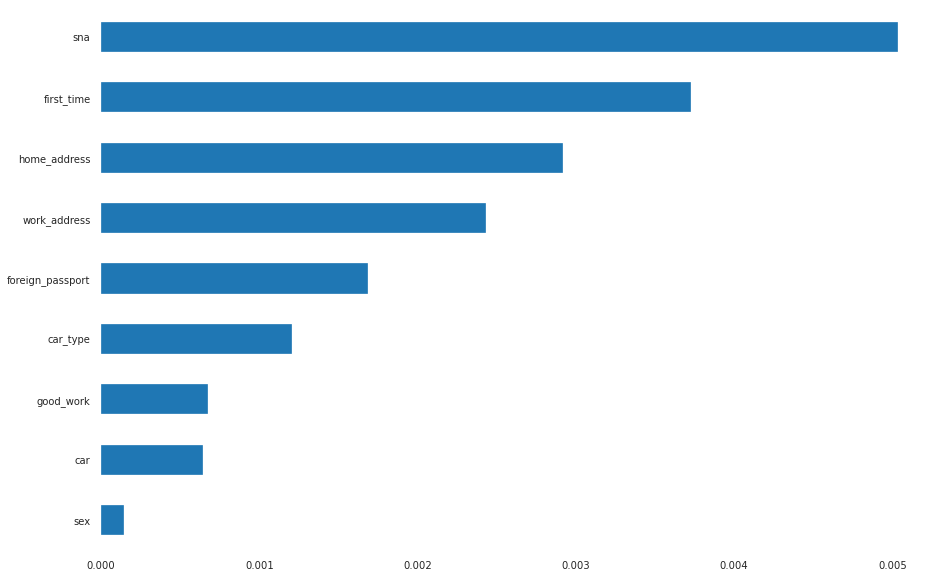

In [376]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols+cat_cols].values, data[target_col].values,
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# т.о. 'car', 'work_address' мы исключаем из входных данных

In [377]:
bin_cols.remove('car')
cat_cols.remove('work_address')

# *Feature engineering*

In [378]:
data['app_date'] = pd.to_datetime(data.app_date)
data['app_date'] = data['app_date'].apply(lambda x: (x - data['app_date'].min()).days) # число дней с минимальной даты

In [379]:
#средний доход для возраста
mean_income = data.groupby('age')['income'].mean().to_dict() #средний доход для возраста
data['mean_income_age'] = data['age'].map(mean_income)
num_cols += ['mean_income_age']

In [380]:
#макс доход для возраста
max_income = data.groupby('age')['income'].max().to_dict()
data['max_income_age'] = data['age'].map(max_income)
num_cols += ['max_income_age']

In [381]:
# нормализуем доход по отношению к макс. доходу возраста
data["normalized_income"] = abs((data.income - data.mean_income_age)/data.max_income_age)
num_cols += ['normalized_income']

In [382]:
# requests to BKI by age
mean_bki = data.groupby('age')['bki_request_cnt'].mean().to_dict()
data['mean_requests_age'] = data['age'].map(mean_bki)
num_cols += ['mean_requests_age']

In [383]:
# mean BKI requests by income
mean_bki_inc = data.groupby('income')['bki_request_cnt'].mean().to_dict()
data['mean_requests_income'] = data['income'].map(mean_bki_inc)
num_cols += ['mean_requests_income']

In [384]:
# Mean income by region
mean_income_rat = data.groupby('region_rating')['income'].mean().to_dict()
data['mean_income_region'] = data['region_rating'].map(mean_income_rat)
num_cols += ['mean_income_region']

обобщим эту идею на комбинации разных численных признаков, где может быть взаимосвязь, обернем логику в функцию: 

In [385]:
#Отображение значения x_col на среднее f_col для этого значения. 
def ConnectFeatures(df, f_col, x_col):
    global num_cols
    new_vals = df.groupby(x_col)[f_col].mean().to_dict()
    new_colname = f_col+'_'+x_col
    df[new_colname] = df[x_col].map(new_vals)
    num_cols += [new_colname]
    return df
    
data = ConnectFeatures(data, 'income', 'education')
data = ConnectFeatures(data, 'income', 'decline_app_cnt')
data = ConnectFeatures(data, 'income', 'bki_request_cnt')
data = ConnectFeatures(data, 'age', 'education')
data = ConnectFeatures(data, 'bki_request_cnt', 'education')
data = ConnectFeatures(data, 'bki_request_cnt', 'decline_app_cnt')
data = ConnectFeatures(data, 'decline_app_cnt', 'score_bki')
data = ConnectFeatures(data, 'decline_app_cnt', 'bki_request_cnt')
data = ConnectFeatures(data, 'decline_app_cnt', 'age')



In [386]:

data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'sample',
       'mean_income_age', 'max_income_age', 'normalized_income',
       'mean_requests_age', 'mean_requests_income', 'mean_income_region',
       'income_education', 'income_decline_app_cnt', 'income_bki_request_cnt',
       'age_education', 'bki_request_cnt_education',
       'bki_request_cnt_decline_app_cnt', 'decline_app_cnt_score_bki',
       'decline_app_cnt_bki_request_cnt', 'decline_app_cnt_age'],
      dtype='object')

посмотрим на выбросы в числовых признаках...

In [387]:

for col in num_cols:
    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    print("Columns: ", col)
    print('25%: {},'.format(perc25), '75%: {},'.format(perc75), 
          "IQR: {}, ".format(IQR),"Borderline: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))


Columns:  age
25%: 30.0, 75%: 48.0, IQR: 18.0,  Borderline: [3.0, 75.0].
Columns:  decline_app_cnt
25%: 0.0, 75%: 0.0, IQR: 0.0,  Borderline: [0.0, 0.0].
Columns:  score_bki
25%: -2.2604336700000003, 75%: -1.5678881525, IQR: 0.6925455175000004,  Borderline: [-3.299251946250001, -0.5290698762499992].
Columns:  income
25%: 9.90353755128617, 75%: 10.778977123006351, IQR: 0.8754395717201806,  Borderline: [8.590378193705899, 12.092136480586621].
Columns:  bki_request_cnt
25%: 0.0, 75%: 1.3862943611198906, IQR: 1.3862943611198906,  Borderline: [-2.0794415416798357, 3.465735902799726].
Columns:  region_rating
25%: 50.0, 75%: 60.0, IQR: 10.0,  Borderline: [35.0, 75.0].
Columns:  mean_income_age
25%: 10.305358726970132, 75%: 10.444420558250247, IQR: 0.13906183128011484,  Borderline: [10.096765980049959, 10.653013305170418].
Columns:  max_income_age
25%: 13.353476685668044, 75%: 13.81451105863119, IQR: 0.4610343729631463,  Borderline: [12.661925126223323, 14.506062618075909].
Columns:  normalize

# Modeling

In [388]:
train_df = data.query('sample == 1')

X_train, X_valid, Y_train, Y_valid = GetSelection(train_df,
                num_cols = num_cols,
                bin_cols = bin_cols,
                cat_cols = cat_cols,
                ord_cols = ord_cols,
                target_col = target_col,
                test_size=0.2,
                random_state=42)



сначала делаем модель безничего, только с max_iter=1000, random_state=42. как отправную точку

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[train] precision = 0.52
[valid] precision = 0.46
[train] recall = 0.03
[valid] recall = 0.02
[train] F1-score = 0.05
[valid] F1-score = 0.04


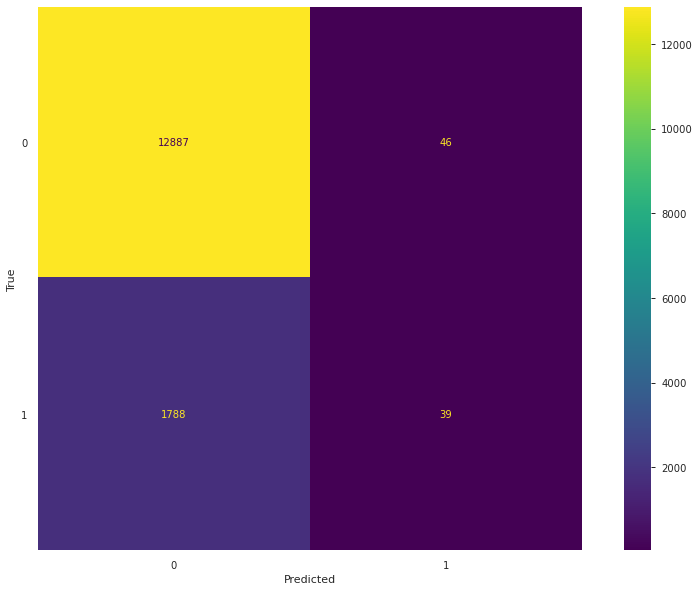

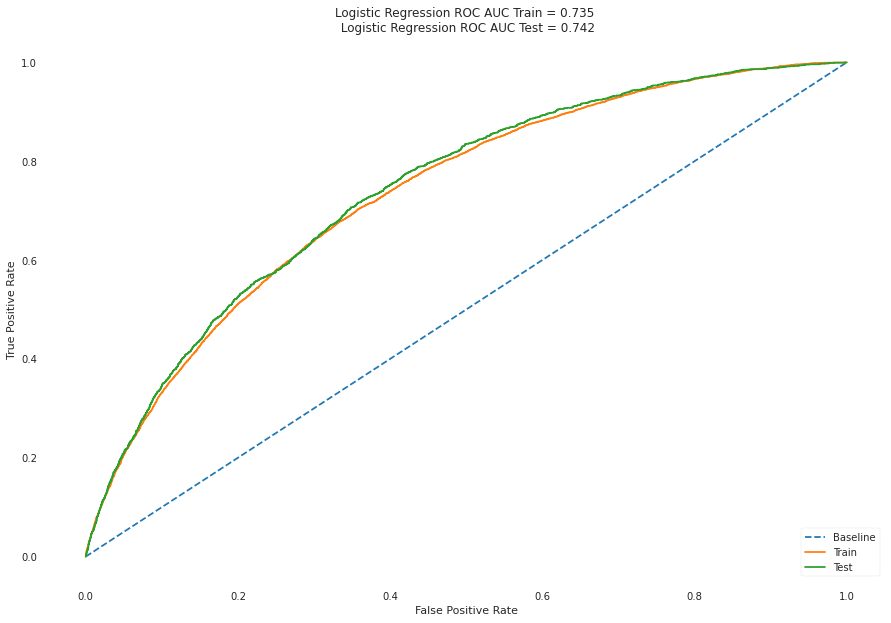

In [389]:
classifier = LogisticRegression(max_iter=300, random_state=42)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_valid)
Y_train_pred = classifier.predict(X_train)
CalcMetrics(X_train, X_valid, Y_train, Y_valid, Y_train_pred, Y_pred)

как и следовало ожидать, без балансировки она плохо предсказывает дефолтных клиентов, заточена всем говорить "да". class_weight=balanced исправит проблему.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[train] precision = 0.23
[valid] precision = 0.22
[train] recall = 0.68
[valid] recall = 0.69
[train] F1-score = 0.34
[valid] F1-score = 0.34


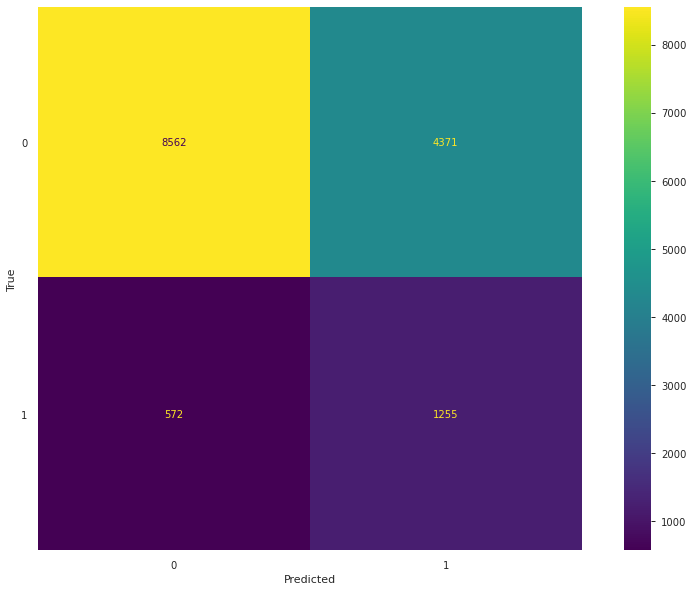

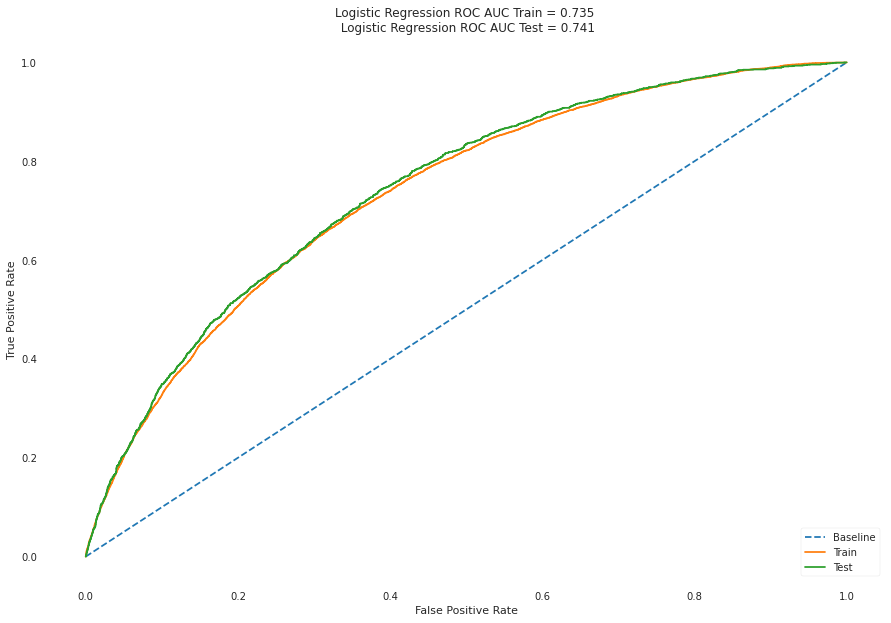

In [390]:
classifier = LogisticRegression(class_weight='balanced', max_iter=300, random_state=42)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_valid)
Y_train_pred = classifier.predict(X_train)
CalcMetrics(X_train, X_valid, Y_train, Y_valid, Y_train_pred, Y_pred)

Предсказания стали более сбалансированы.
Теперь добавим поиск оптимальных гиперпараметров

In [391]:

from sklearn.model_selection import GridSearchCV
# ищем оптимальные значения гиперпараметров
model = LogisticRegression(class_weight='balanced', random_state=42)
param_grid = [
    {
        'penalty': ['none', 'l1', 'l2', 'elasticnet'], 
        'class_weight': ['balanced'],
        'solver': ['newton-cg', 'liblinear', 'lbfgs', 'sag', 'saga'], 
        'multi_class': ['auto','ovr', 'multinomial'],
        'C':[0.1, 0.3, 0.5, 0.8, 1]
    }
]

'''
ПОИСК ЗАНИМАЕТ НЕСКОЛЬКО ЧАСОВ! ниже написал его результаты работы за ночь

gridsearch = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1)
gridsearch.fit(X_train, Y_train)
model = gridsearch.best_estimator_
## печатаем параметры
best_parameters = model.get_params()
for param_name in best_parameters:
    print(param_name, best_parameters[param_name], '\n')
    

'''        


"\nПОИСК ЗАНИМАЕТ НЕСКОЛЬКО ЧАСОВ! ниже написал его результаты работы за ночь\n\ngridsearch = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1)\ngridsearch.fit(X_train, Y_train)\nmodel = gridsearch.best_estimator_\n## печатаем параметры\nbest_parameters = model.get_params()\nfor param_name in best_parameters:\n    print(param_name, best_parameters[param_name], '\n')\n    \n\n"

C 0.1 

class_weight balanced 

dual False 

fit_intercept True 

intercept_scaling 1 

l1_ratio None 

max_iter 100 

multi_class multinomial 

n_jobs None 

penalty l2 

random_state 42 

solver lbfgs 

tol 0.0001 

verbose 0 

warm_start False 

[train] precision = 0.23
[valid] precision = 0.22
[train] recall = 0.68
[valid] recall = 0.69
[train] F1-score = 0.34
[valid] F1-score = 0.34


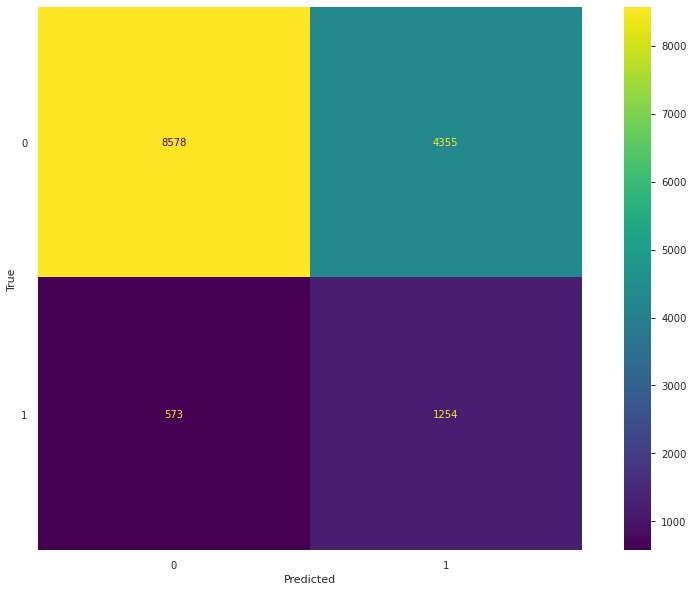

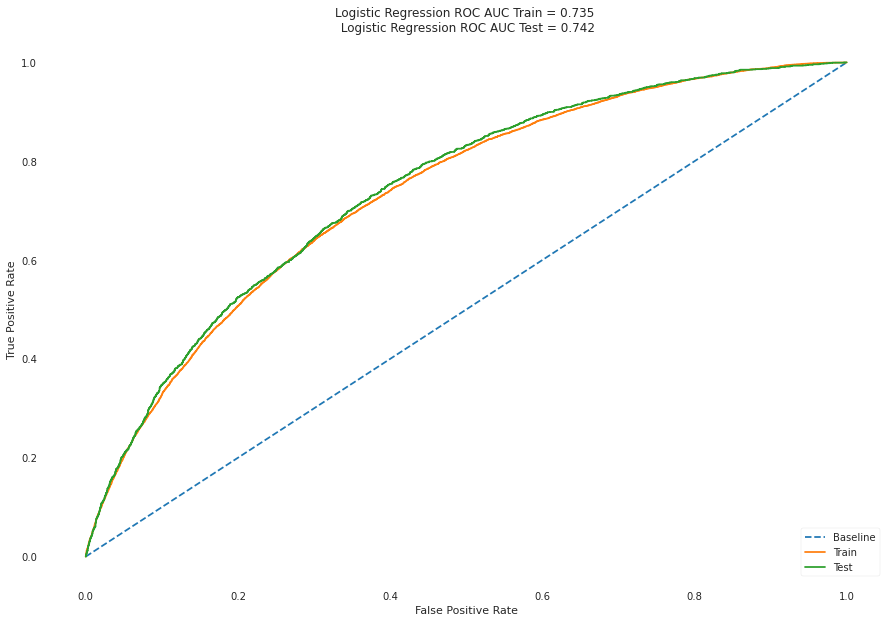

In [392]:
classifier = LogisticRegression(random_state = 42,
                                max_iter = 300,
                                class_weight = 'balanced',
                                
                                C = 0.1,
                                dual = False,
                                fit_intercept = True,
                                intercept_scaling = 1, 
                                l1_ratio = None, 
                                multi_class = 'multinomial', 
                                n_jobs = -1,
                                penalty ='l2',
                                solver = 'lbfgs', 
                                tol = 0.0001, 
                                verbose = 0, 
                                warm_start = False
                               )

classifier.fit(X_train, Y_train)
Y_train_pred = classifier.predict(X_train)
Y_pred = classifier.predict(X_valid)
CalcMetrics(X_train, X_valid, Y_train, Y_valid, Y_train_pred, Y_pred)

в итоге получили сбалансированную модель, предсказывающую с ROC AUC = 0.74 

сделаем предсказания по тестовому набору и запишем в submission.

In [393]:
test_df = data.query('sample == 0')
X_test, Y_test = GetSelection(test_df,
                num_cols = num_cols,
                bin_cols = bin_cols,
                cat_cols = cat_cols,
                ord_cols = ord_cols,
                target_col = target_col,
                test_size=1.0,
                random_state=42)

Y_pred = classifier.predict(X_test)
Y_pred_probs = classifier.predict_proba(X_test)
Y_pred_probs = Y_pred_probs[:,1]

results_df = pd.DataFrame(data={'client_id':test['client_id'], 'default':Y_pred_probs})
results_df.to_csv('submission.csv', index=False)
results_df

,client_id,default
0,74835,0.204475
1,17527,0.786507
2,75683,0.304269
3,26883,0.332858
4,28862,0.097147
...,...,...
36344,83775,0.803806
36345,106254,0.135364
36346,81852,0.800304
36347,1971,0.651265
